# Image GAN

based on: https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt

In [2]:
# load data

# unsupervised so ignoring labels
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float64")
train_images = (train_images - 127.5) / 127.5 # normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# batch and shuffle the data
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
)

## Generator

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(
        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh")
    )
    assert model.output_shape == (None, 28, 28, 1)

    return model


generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

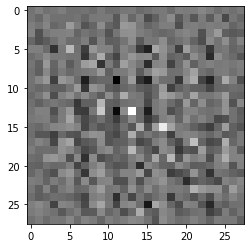

In [4]:
# create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap="gray")

## Discriminator

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model


discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [6]:
# untrained test
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.0036735]], shape=(1, 1), dtype=float32)


## GAN config - Loss & Optimization

In [7]:
# define loss and optimizers for both the generator and the discriminator

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    """
    This method quantifies how well the discriminator is able to distinguish real images from fakes.
    It compares the discriminator's predictions on real images to an array of 1s, and the        
    discriminator's predictions on fake (generated) images to an array of 0s.
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    """
    The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if     the generator is performing well, the discriminator will classify the fake images as real (or 1).
    Here, compare the discriminators decisions on the generated images to an array of 1s.
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Checkpoints

In [8]:
import os

# save the state of the model after each epoch with a checkpoint
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)

## Train the Model

In [9]:
# setup

EPOCHS = 60
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [10]:
# define the training step
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # 1 - Create random noise to feed it into the model
    # for image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differention.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using
    # operations recorded in context of this tape (gen_tape and disc_tape).

    # It accepts a target (e.g., gen_loss) variable and
    # a source variable (e.g. generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated. 
    # source --> a list or nested structure of Tensors of Variables
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list of nested structure of Tensors
    # (of IndexedSlices, or None), one for each element in sources.
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 4 - Process Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregaed gradients.
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce("sum", grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )


In [11]:
def generate_and_save_images(model, epoch, test_input):
    # Notice 'training' is set to False
    # This is so all layers run in inference mode (batchnorm).
    # 1 - Generate images
    predictions = model(test_input, training=False)
    # 2 - Plot the generated images
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 128.5, cmap="gray")
        plt.axis("off")
    # 3 - Save the generated images 
    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

In [12]:
import time
from IPython import display

def train(dataset, epochs):
    # A. For each epoch, do the following:
    for epoch in range(epochs):
        start = time.time()
        # 1 - for each batch of the epoch,
        for image_batch in dataset:
            # 1.a -- run the custom train step function
            train_step(image_batch)

        # 2 - Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 3 - Save the model every 5 epochs as a checkpoint,
        # which we will use later
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # 4 - Print out the completed epoch no. and the time spent
        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec")

    # B. Generate a final image after the training is completed
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

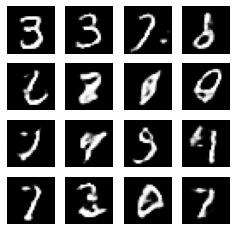

In [13]:
train(train_dataset, EPOCHS)

## Generate Digits